# Basics

## Node and MessageNode

`trace` is a computational graph framework for tracing and optimizing codes. Its core data structure is the "node" container of python objects. To create a node, use `node` method, which creates a `Node` object. To access the content of a node, use the `data` attribute.

In [1]:
from opto.trace import node

x = node(1)  # node of int
print("node of int", x.data)
x = node("string")  # node of str
print(x.data)
x = node([1, 2, 3])  # node of list
print(x.data)
x = node({"a": 1, "b": 2})  # node of dict
print(x.data)


class Foo:
    def __init__(self, x):
        self.x = x
        self.secret = "secret"

    def print(self, val):
        print(val)


x = node(Foo("foo"))  # node of a class instance
print(x.data)

node of int 1
string
[1, 2, 3]
{'a': 1, 'b': 2}


When a computation is performed using the contents of nodes, the result is also a node. This allows for the creation of a computation graph. The computation graph is a directed acyclic graph where the edges indicate the data dependencies.

Nodes that are defined manually can be marked as trainable by setting their `trainable` attribute to True; such nodes are a subclass of Node called `ParameterNode`.
Nodes that are created automatically as a result of computations are a different subclass of Node called `MessageNode`.

Nodes can be copied. This can be done in two ways with `clone` or `detach`

In [2]:
# clone returns a MessageNode whose parent is the original node
x_clone = x.clone()
assert x in x_clone.parents
assert x_clone.data != x.data
assert x_clone.data.x == x.data.x
print(x_clone.data)
# detach returns a new Node which is not connected to the original node
x_detach = x.detach()
assert len(x_detach.parents) == 0
assert x_detach.data != x.data
assert x_detach.data.x == x.data.x

`trace` overloads python's magic methods that gives return value explicitly (such as `__add__`), except logical operations such as `__bool__` and setters. (The comparison magic methods instead compare nodes according to the computation graph that will be explained later, rather than comparing the data.) 

When nodes are used with these magic methods, the output would be a `MessageNode`, which is a subclass of `Node` that has the inputs of the method as the parents. The attribute `description` of a `MessageNode` documents the method's function.

In [3]:
def print_node(node):
    print(node)
    print(f"parents: {[p.name for p in node.parents]}")


# Basic arithmetic operations
x = node(1, name="node_x")
y = node(3, name="node_y")
z = x / y
z2 = x / 3  # the int 3 would be converted to a node automatically
print(z)
print_node(z)
print("\n")

# Index a node
dict_node = node({"a": 1, "b": 2}, name="dict_node")
a = dict_node["a"]
print_node(a)
print("len(dict_node) =", dict_node.len())

print("\n")

# Getting class attribute and calling class method
x = node(Foo("foo"))
x.call("print", "hello world")
print_node(x.getattr("secret"))

MessageNode: (divide:0, dtype=<class 'float'>, data=0.3333333333333333)
MessageNode: (divide:0, dtype=<class 'float'>, data=0.3333333333333333)
parents: ['node_x:0', 'node_y:0']


MessageNode: (getitem:0, dtype=<class 'int'>, data=1)
parents: ['dict_node:0', 'str:1']
len(dict_node) = MessageNode: (len_:0, dtype=<class 'int'>, data=2)


Node: (str:3, dtype=<class 'str'>, data=hello world)
MessageNode: (node_getattr:1, dtype=<class 'str'>, data=secret)
parents: ['Foo:1', 'str:4']


Nodes can not be used in logical operations like `and`, `or`, `not`. This is an explicit design choice so as to ensure that logical operations in python code are explicitly traced.

In [4]:
x = node(True)
try:
    if x:
        print("True")
except Exception as e:
    print(e)
    print("Use if x.data instead of if x")


x = node([1, 2, 3])
try:
    print(1 in x)
except Exception as e:
    print(e)
    print("Use 1 in x.data instead of 1 in x")

True
True


Nodes can be used to encapsulate any python object, including functions. Here are a few examples.

In [5]:
def fun(x):
    return x + 1


fun_node = node(fun)
y = fun_node(node(1))
print(f"output: {y}\nparents {[(p.name, p.data) for p in y.parents]}")
print("\n\n")


class Foo:

    def __init__(self):
        self.node = node(1)
        self.non_node = 2

    def trace_fun(self):
        return self.node * 2

    def non_trace_fun(self):
        return self.non_node * 2


foo = node(Foo())

try:
    foo.node
    foo.trace_fun()
except AttributeError:
    print("The attribute of the wrapped object cannot be directly accessed. Instead use getattr() or call()")


attr = foo.getattr("node")
print(f"foo_node: {attr}\nparents {[(p.name, p.data) for p in attr.parents]}")


attr = foo.getattr("non_node")
print(f"non_node: {attr}\nparents {[(p.name, p.data) for p in attr.parents]}")


fun = foo.getattr("non_trace_fun")
y = fun()
print(f"output: {y}\nparents {[(p.name, p.data) for p in y.parents]}")

try:
    fun = foo.getattr("trace_fun")
    y = fun()
except AssertionError as e:
    print(e)

y = foo.call("non_trace_fun")
print(f"output: {y}\nparents {[(p.name, p.data) for p in y.parents]}")

try:
    y = foo.call("trace_fun")
except AssertionError as e:
    print(e)

output: MessageNode: (call:1, dtype=<class 'int'>, data=2)
parents [('function:0', <function fun at 0x00000233CF64AC10>), ('int:3', 1)]



The attribute of the wrapped object cannot be directly accessed. Instead use getattr() or call()
foo_node: MessageNode: (node_getattr:2, dtype=<class 'int'>, data=1)
parents [('Foo:2', <__main__.Foo object at 0x00000233CF730FA0>), ('str:5', 'node')]
non_node: MessageNode: (node_getattr:3, dtype=<class 'int'>, data=2)
parents [('Foo:2', <__main__.Foo object at 0x00000233CF730FA0>), ('str:6', 'non_node')]
output: MessageNode: (call:2, dtype=<class 'int'>, data=4)
parents [('node_getattr:4', <bound method Foo.non_trace_fun of <__main__.Foo object at 0x00000233CF730FA0>>)]
output: MessageNode: (call:4, dtype=<class 'int'>, data=4)
parents [('node_getattr:6', <bound method Foo.non_trace_fun of <__main__.Foo object at 0x00000233CF730FA0>>)]


## Writing Custom Node Operators

In addition to magic methods, we can use `bundle` to write custom methods that are traceable. When decorating a method with `bundle`, it needs a description of the method. It has a format of `[method_name] description`. `bundle` will automatically add all nodes whose `data` attribute is used within the function as the parents of the output `MessageNode`.

Given a function `fun`, the decorated function by default will unpack all the inputs (i.e. it unpacks all the data inside nodes), send them to `fun`, and then creates a `MessageNode` to wrap the output of `fun` which has parents containing all the nodes used in this operation. 

In [6]:
from opto.trace import bundle, GRAPH
from opto.trace.nodes import Node

GRAPH.clear()

@bundle()
def add(x):
    """
    Add 1 to input x
    """
    return x + 1


x = node(1, name="node_x")
z = add(x)
print_node(z)
print("\n")


@bundle()
def add(x, y):
    """
    Add input x and input y
    """
    return x + y


x = node(1, name="node_x")
y = node(2, name="node_y")
z = add(x, y)
print_node(z)
print("\n")

# The output is a node of a tuple of two nodes


@bundle()
def pass_through(x, y):
    """
    No operation, just return inputs
    """
    return x, y


x = node(1, name="node_x")
y = node(2, name="node_y")
z = pass_through(x, y)
print(z)

assert isinstance(z, Node)
assert isinstance(z.data, tuple)
assert len(z.data) == 2
print("\n")

MessageNode: (add:0, dtype=<class 'int'>, data=2)
parents: ['node_x:0']


MessageNode: (add:1, dtype=<class 'int'>, data=3)
parents: ['node_x:1', 'node_y:0']


MessageNode: (pass_through:0, dtype=<class 'tuple'>, data=(1, 2))




## Visualize Graph

The graph of nodes can be visualized by calling `backward` method of a node. (Later we will cover how `backward` also sends feedback across the graph). 

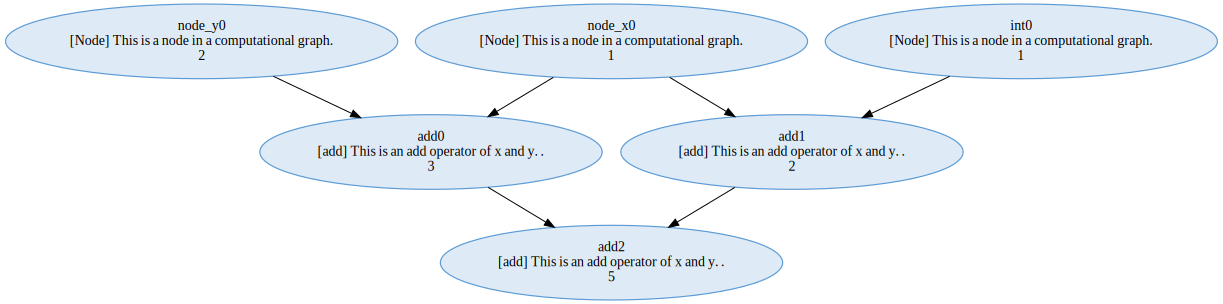

In [7]:
from opto.trace.nodes import GRAPH

GRAPH.clear()  # to remove all the nodes
x = node(1, name="node_x")
y = node(2, name="node_y")
a = x + y
b = x + 1
final = a + b
final.backward(visualize=True)

Node: (bool:0, dtype=<class 'bool'>, data=True) Node: (int:0, dtype=<class 'int'>, data=1) Node: (int:1, dtype=<class 'int'>, data=0)


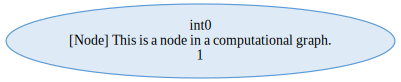

In [8]:
GRAPH.clear()
x = node(True)
one = node(1)
zero = node(0)
print(x, one, zero)
# Logical operations are not traceable
y = one if x.data else zero
y.backward(visualize=True)

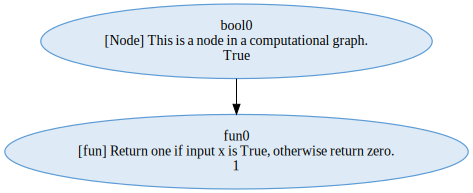

In [9]:
# This is traceable
@bundle(allow_external_dependencies=True)
def fun(x):
    """
    Return one if input x is True, otherwise return zero
    """
    return one.data if x else zero.data


y = fun(x)
y.backward(visualize=True)

## Broadcasting
Using `apply_op`, we can broadcast node operators to a container of nodes. A container of nodes are either `list`, `tuple`, `dict`, or subclass of an abstract class `BaseModule`. `apply_op` recursively applies the operator to all nodes in the container. 

In [10]:
from opto.trace import apply_op, node, NodeContainer
from opto.trace import operators as ops

import copy

# Using list as a node container
x = [node(1), node(2), 1]
y = [node(3), node(4), 2]
z = copy.deepcopy(x)
z = apply_op(ops.add, z, x, y)
print("x", [x[0].data, x[1].data, x[2]])
print("y", [y[0].data, y[1].data, y[2]])
print("Elements in z should be added, except for the last one. Value: ", [z[0].data, z[1].data, z[2]])


# Using list as a node container
x = dict(a=node(1), b=0)
y = dict(a=node(3), b=0)
z = copy.deepcopy(x)
z = apply_op(ops.add, z, x, y)
print(f"{x['a'].data}+{y['a'].data}={z['a'].data}")
print(f"{x['b']}=={y['b']}=={z['b']}")

# Using a custom class as a node container


class Foo(NodeContainer):
    def __init__(self, x):
        self.x = node(x)
        self.y = [node(1), node(2)]
        self.z = 1


x = Foo("x")
y = Foo("y")
x_plus_y = Foo("template")
x_plus_y = apply_op(ops.add, x_plus_y, x, y)
print("x_plus_y.x should be added. Value: ", x_plus_y.x.data)
print("x_plus_y.y should be added. Value: ", [n.data for n in x_plus_y.y])
print("x_plus_y.z should be not added, just 1. Value: ", x_plus_y.z)

x [1, 2, 1]
y [3, 4, 2]
Elements in z should be added, except for the last one. Value:  [4, 6, 1]
1+3=4
0==0==0
x_plus_y.x should be added. Value:  xy
x_plus_y.y should be added. Value:  [2, 4]
x_plus_y.z should be not added, just 1. Value:  1


## Nodes and Python Data Structure

We can create a `node` over Python data structure like dictionary, tuple, set, or list. We automatically handle the iteration and you can wrap a node around any data structure and use them like normal python objects.

MessageNode: (getitem:0, dtype=<class 'str'>, data=arg2)
MessageNode: (getitem:1, dtype=<class 'str'>, data=arg1)


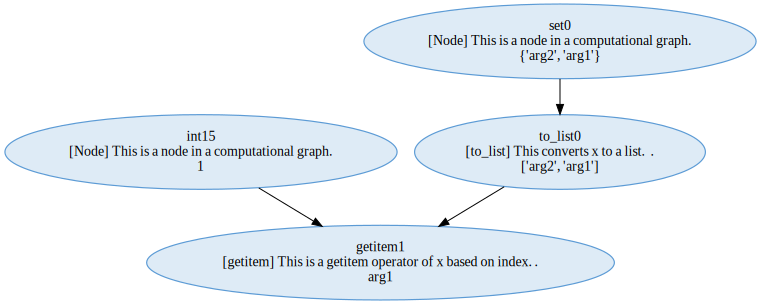

In [11]:
from opto.trace import node

args = node({"arg1", "arg2"}, trainable=False)
for a in args:
    print(a)

a.backward(visualize=True)

MessageNode: (getitem:2, dtype=<class 'str'>, data=arg1) MessageNode: (getitem:3, dtype=<class 'int'>, data=1)
MessageNode: (getitem:4, dtype=<class 'str'>, data=arg2) MessageNode: (getitem:5, dtype=<class 'int'>, data=2)


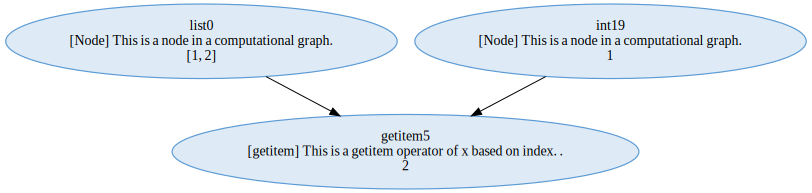

In [12]:
parms = node([1, 2], trainable=False)
args = node(["arg1", "arg2"], trainable=False)

for a, p in zip(args, parms):
    print(a, p)

p.backward(visualize=True)